## Effective surface heat capacity calculation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [5]:
ctl_300 = xr.open_dataset('./../data_isca/clouds_T21_GA7_300ppm_alb0.2_mean.nc')
weights = np.cos(np.deg2rad(ctl_300.lat))
weights.name = "weights"
land=ctl_300.ml_heat_cap.mean('months') < 8257740
ocean=ctl_300.ml_heat_cap.mean('months') > 8257740

In [12]:
ctl_300.keys()

KeysView(<xarray.Dataset>
Dimensions:                    (lat: 32, latb: 33, lon: 64, lonb: 65, months: 12, nv: 2, pfull: 20)
Coordinates:
  * pfull                      (pfull) float32 1000.0 950.0 900.0 ... 100.0 50.0
  * lonb                       (lonb) float64 -2.812 2.812 8.438 ... 351.6 357.2
  * lon                        (lon) float64 0.0 5.625 11.25 ... 348.8 354.4
  * lat                        (lat) float64 -85.76 -80.27 ... 80.27 85.76
  * nv                         (nv) float64 1.0 2.0
  * latb                       (latb) float64 -90.0 -83.21 -77.61 ... 83.21 90.0
  * months                     (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    height                     (months, pfull, lat, lon) float32 ...
    slp                        (months, lat, lon) float32 940.029 ... 947.7904
    ps                         (months, lat, lon) float32 94002.9 ... 94779.05
    zsurf                      (months, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    precipitation   

In [77]:
def integrate_ts(sw,lw_down,lhe,sh,C):
    dt = 3600*24*30
    timesteps = 10
    ts = 200
    ts_array = (sw*0).rename('t_surf_rec')
    for j in np.arange(2):
        for month in np.arange(12):
            i=0
            while(i<timesteps):
                ts += (sw.isel(months=month)+lw_down.isel(months=month)-5.67e-8*ts**4-lhe.isel(months=month)-sh.isel(months=month))/C*dt/timesteps
                i+=1
            ts_array[month]=ts
    return ts_array

In [78]:
bla = integrate_ts(ctl_300.soc_surf_flux_sw.where(land).mean('lon').where(ctl_300.lat>70).weighted(weights).mean('lat'),
                   ctl_300.soc_surf_flux_lw_down.where(land).mean('lon').where(ctl_300.lat>70).weighted(weights).mean('lat'),
                   ctl_300.flux_lhe.where(land).mean('lon').where(ctl_300.lat>70).weighted(weights).mean('lat'),
                   ctl_300.flux_t.where(land).mean('lon').where(ctl_300.lat>70).weighted(weights).mean('lat'),
                   1e7)

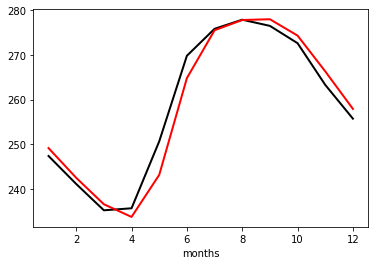

In [51]:
bla.plot(c='k',lw=2)
ctl_300.t_surf.where(land).mean('lon').where(ctl_300.lat>70).weighted(weights).mean('lat').plot(c='r',lw=2)

In [64]:
cesm_6x_ts = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-ts-v1.0.mean.nc')
cesm_6x_lh = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-hfls-v1.0.mean.nc')
cesm_6x_sh = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-hfss-v1.0.mean.nc')
cesm_6x_lw_down = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-rlds-v1.0.mean.nc')
cesm_6x_sw_down = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-rsds-v1.0.mean.nc')
cesm_6x_sw_up = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_stand_6xCO2-rsus-v1.0.mean.nc')
cesm_sftlf = xr.open_dataset('./../data_eocene/CESM1.2_CAM5-deepmip_sens_1xCO2-sftlf-v1.0.mean.nc').mean('month')
weights = np.cos(np.deg2rad(cesm_6x_ts.lat))
weights.name = "weights"

In [87]:
def integrate_ts(sw,lw_down,lhe,sh,C):
    dt = 3600*24*30
    timesteps = 10
    ts = 200
    ts_array = (sw*0).rename('t_surf_rec')
    for j in np.arange(2):
        for time in np.arange(12):
            i=0
            while(i<timesteps):
                ts += (sw.isel(month=time)+lw_down.isel(month=time)-5.67e-8*ts**4-lhe.isel(month=time)-sh.isel(month=time))/C*dt/timesteps
                i+=1
            ts_array[time]=ts
    return ts_array

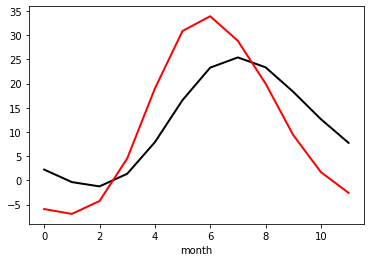

In [111]:
bla = integrate_ts((cesm_6x_sw_down.rsds-cesm_6x_sw_up.rsus).where(cesm_sftlf.sftlf>0.99).mean('lon').where(cesm_sftlf.lat>70).weighted(weights).mean('lat'),
                   cesm_6x_lw_down.rlds.where(cesm_sftlf.sftlf>0.99).mean('lon').where(cesm_sftlf.lat>70).weighted(weights).mean('lat'),
                   cesm_6x_lh.hfls.where(cesm_sftlf.sftlf>0.99).mean('lon').where(cesm_sftlf.lat>70).weighted(weights).mean('lat'),
                   cesm_6x_sh.hfss.where(cesm_sftlf.sftlf>0.99).mean('lon').where(cesm_sftlf.lat>70).weighted(weights).mean('lat'),
                   4e7)

(bla-273).plot(c='k',lw=2)
(cesm_6x_ts.ts-273).where(cesm_sftlf.sftlf>0.99).mean('lon').where(cesm_sftlf.lat>70).weighted(weights).mean('lat').plot(c='r',lw=2)